<a href="https://colab.research.google.com/github/igornunespatricio/BairesDev-Machine-Learning-Practitioner/blob/main/YOLO_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Create a directory for the dataset
!mkdir -p coco

# Change to the dataset directory
%cd coco

# Download train images
!wget http://images.cocodataset.org/zips/train2017.zip

# Download validation images
!wget http://images.cocodataset.org/zips/val2017.zip

# Download annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip


/content/coco
--2024-11-28 20:10:06--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.2.201, 54.231.230.89, 16.182.40.137, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.2.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  48.8MB/s    in 5m 23s  

2024-11-28 20:15:29 (57.1 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-11-28 20:15:29--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.17.0, 52.216.145.75, 54.231.168.17, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.17.0|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.

In [ ]:
# Extract train images
!unzip -q train2017.zip

# Extract validation images
!unzip -q val2017.zip

# Extract annotations
!unzip -q annotations_trainval2017.zip

In [ ]:
!rm *.zip

In [ ]:
# Count images in the training dataset
!find /content/coco/train2017 -type f -name "*.jpg" | wc -l

# Count images in the validation dataset
!find /content/coco/val2017 -type f -name "*.jpg" | wc -l


118287
5000


In [ ]:
import os

# Define the paths to the COCO dataset directories
train_path = '/content/coco/train2017'
val_path = '/content/coco/val2017'

# Count the number of images in the training dataset
num_train_images = len([f for f in os.listdir(train_path) if f.endswith('.jpg')])

# Count the number of images in the validation dataset
num_val_images = len([f for f in os.listdir(val_path) if f.endswith('.jpg')])

print(f"Number of images in the training dataset: {num_train_images}")
print(f"Number of images in the validation dataset: {num_val_images}")


Number of images in the training dataset: 118287
Number of images in the validation dataset: 5000


In [ ]:
%cd ..

/content


In [ ]:
!ls

coco  sample_data


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install pycocotools
!pip install opencv-python-headless

In [ ]:
import os
import json
import cv2
import shutil
from tqdm import tqdm
import yaml
from pycocotools.coco import COCO

# Define paths
train_annotations_file = '/content/coco/annotations/instances_train2017.json'
val_annotations_file = '/content/coco/annotations/instances_val2017.json'
train_images_dir = '/content/coco/train2017'
val_images_dir = '/content/coco/val2017'
output_dir = '/content/yolo_coco'

# Create output directories for YOLO format
yolo_train_dir = os.path.join(output_dir, 'train')
yolo_val_dir = os.path.join(output_dir, 'val')
yolo_train_images_dir = os.path.join(yolo_train_dir, 'images')
yolo_val_images_dir = os.path.join(yolo_val_dir, 'images')
yolo_train_labels_dir = os.path.join(yolo_train_dir, 'labels')
yolo_val_labels_dir = os.path.join(yolo_val_dir, 'labels')

os.makedirs(yolo_train_images_dir, exist_ok=True)
os.makedirs(yolo_val_images_dir, exist_ok=True)
os.makedirs(yolo_train_labels_dir, exist_ok=True)
os.makedirs(yolo_val_labels_dir, exist_ok=True)

# Load COCO annotations
coco_train = COCO(train_annotations_file)
coco_val = COCO(val_annotations_file)

# Create category mapping: COCO category IDs to YOLO zero-based IDs
categories = coco_train.loadCats(coco_train.getCatIds())
category_mapping = {category['id']: i for i, category in enumerate(categories)}

# Function to convert COCO bounding box to YOLO format
def coco_to_yolo_format(image_id, annotation, coco_obj, img_dir):
    x, y, width, height = annotation['bbox']
    img_info = coco_obj.loadImgs(image_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    img = cv2.imread(img_path)
    img_height, img_width = img.shape[:2]

    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width_normalized = width / img_width
    height_normalized = height / img_height

    category_id = category_mapping[annotation['category_id']]  # Map to YOLO ID
    return f"{category_id} {x_center} {y_center} {width_normalized} {height_normalized}\n"

# Function to process COCO annotations and save in YOLO format, while copying images
def convert_annotations(coco_obj, image_ids, img_dir, output_folder, image_output_dir):
    for image_id in tqdm(image_ids, desc=f"Converting {output_folder} annotations", unit="image"):
        annotations = coco_obj.loadAnns(coco_obj.getAnnIds(imgIds=[image_id]))

        img_info = coco_obj.loadImgs(image_id)[0]
        source_image_path = os.path.join(img_dir, img_info['file_name'])

        # Remove leading zeros from image_id
        image_name = f"{int(image_id)}.jpg"
        target_image_path = os.path.join(image_output_dir, image_name)

        # Copy the image
        shutil.copy(source_image_path, target_image_path)

        # Prepare YOLO annotation file
        yolo_annotation_file = os.path.join(output_folder, 'labels', f"{image_id}.txt")
        with open(yolo_annotation_file, 'w') as file:
            for annotation in annotations:
                yolo_annotation = coco_to_yolo_format(image_id, annotation, coco_obj, img_dir)
                file.write(yolo_annotation)

# Get the first 500 training annotations (change as needed)
train_image_ids = coco_train.getImgIds()[:500]
val_image_ids = coco_val.getImgIds()[:50]

# Convert training and validation annotations, copying images as needed
convert_annotations(coco_train, train_image_ids, train_images_dir, yolo_train_dir, yolo_train_images_dir)
convert_annotations(coco_val, val_image_ids, val_images_dir, yolo_val_dir, yolo_val_images_dir)

# Prepare the dataset YAML file for YOLOv8
dataset_yaml = {
    'train': yolo_train_dir,
    'val': yolo_val_dir,
    'nc': len(categories),  # Number of classes
    'names': [category['name'] for category in categories]  # Class names
}

# Save the dataset.yaml file
yaml_file_path = os.path.join(output_dir, 'dataset.yaml')
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(dataset_yaml, yaml_file)

print(f"\nDataset YAML saved to {yaml_file_path}.")


loading annotations into memory...
Done (t=20.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


Converting /content/yolo_coco/val annotations: 100%|██████████| 50/50 [00:01<00:00, 29.66image/s]


Dataset YAML saved to /content/yolo_coco/dataset.yaml.


In [ ]:
import os

# Define the paths to the COCO dataset directories
train_path = '/content/yolo_coco/train/images'
val_path = '/content/yolo_coco/val/images'

# Count the number of images in the training dataset
num_train_images = len([f for f in os.listdir(train_path) if f.endswith('.jpg')])

# Count the number of images in the validation dataset
num_val_images = len([f for f in os.listdir(val_path) if f.endswith('.jpg')])

print(f"Number of images in the training dataset: {num_train_images}")
print(f"Number of images in the validation dataset: {num_val_images}")


Number of images in the training dataset: 500
Number of images in the validation dataset: 50


In [ ]:
!pip install ultralytics -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 52.5/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [16]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # Use the lightweight model for faster results

# Train the model, freezing the backbone layers
model.train(
    data='/content/yolo_coco/dataset.yaml',  # Path to dataset YAML
    epochs=4,
    batch=16,
    imgsz=640,
    device='cuda',
    workers=4,
    patience=10,
    freeze=[0, 10],  # Freeze the first 10 layers (classification head is not frozen)
)

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolo_coco/dataset.yaml, epochs=4, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=[0, 10], multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

train: Scanning /content/yolo_coco/train/labels.cache... 500 images, 13 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_coco/val/labels.cache... 50 images, 2 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4      2.79G      1.242      1.467      1.265         17        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         50        382       0.51      0.592      0.567      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4      2.91G      1.219      1.353      1.239        105        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         50        382      0.545      0.548       0.55      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4      2.69G       1.22      1.316      1.241        111        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         50        382      0.579      0.515      0.539      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4      2.76G      1.148      1.258      1.214         73        640: 100%|██████████| 32/32 [00:09<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         50        382      0.709      0.436      0.548      0.394



4 epochs completed in 0.022 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


                   all         50        382       0.51      0.591      0.566      0.423
                person         23        127       0.59      0.709      0.709      0.423
               bicycle          3          4      0.245        0.5      0.537      0.429
                   car          7         34      0.411      0.824      0.738      0.535
            motorcycle          3         10      0.707      0.484      0.644      0.373
              airplane          1          2      0.778        0.5      0.578      0.281
                   bus          6          8      0.694       0.75      0.813      0.686
                 train          2          2      0.552          1      0.995      0.798
                 truck          3          5       0.27        0.6      0.367      0.323
                  boat          3         15      0.457      0.333      0.328      0.215
         traffic light          3          6      0.171      0.167     0.0997      0.075
             stop sig

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 18, 19, 20, 23, 24, 25, 26, 27, 28, 36, 39, 41, 43, 44, 45, 46, 49, 50, 51, 56, 57, 58, 60, 61, 62, 63, 66, 69, 71, 72, 73, 74, 75])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c13c270efb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034, 

In [29]:
from ultralytics import YOLO

# Load your trained YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # Adjust path if needed

# Perform detection directly from the URL
image_url = 'https://advancelocal-adapter-image-uploads.s3.amazonaws.com/image.mlive.com/home/mlive-media/width2048/img/grpress/news_impact/photo/fulton-street-traffic-signals-synchronized-45d0b70ef344b19f.jpg'
results = model.predict(
    source=image_url,
    save=True,
    show=True,
    imgsz=1248,
    line_width=2  # Adjust the bounding box thickness
)
# Output results
print(results)


WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.

Found https://advancelocal-adapter-image-uploads.s3.amazonaws.com/image.mlive.com/home/mlive-media/width2048/img/grpress/news_impact/photo/fulton-street-traffic-signals-synchronized-45d0b70ef344b19f.jpg locally at fulton-street-traffic-signals-synchronized-45d0b70ef344b19f.jpg
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream

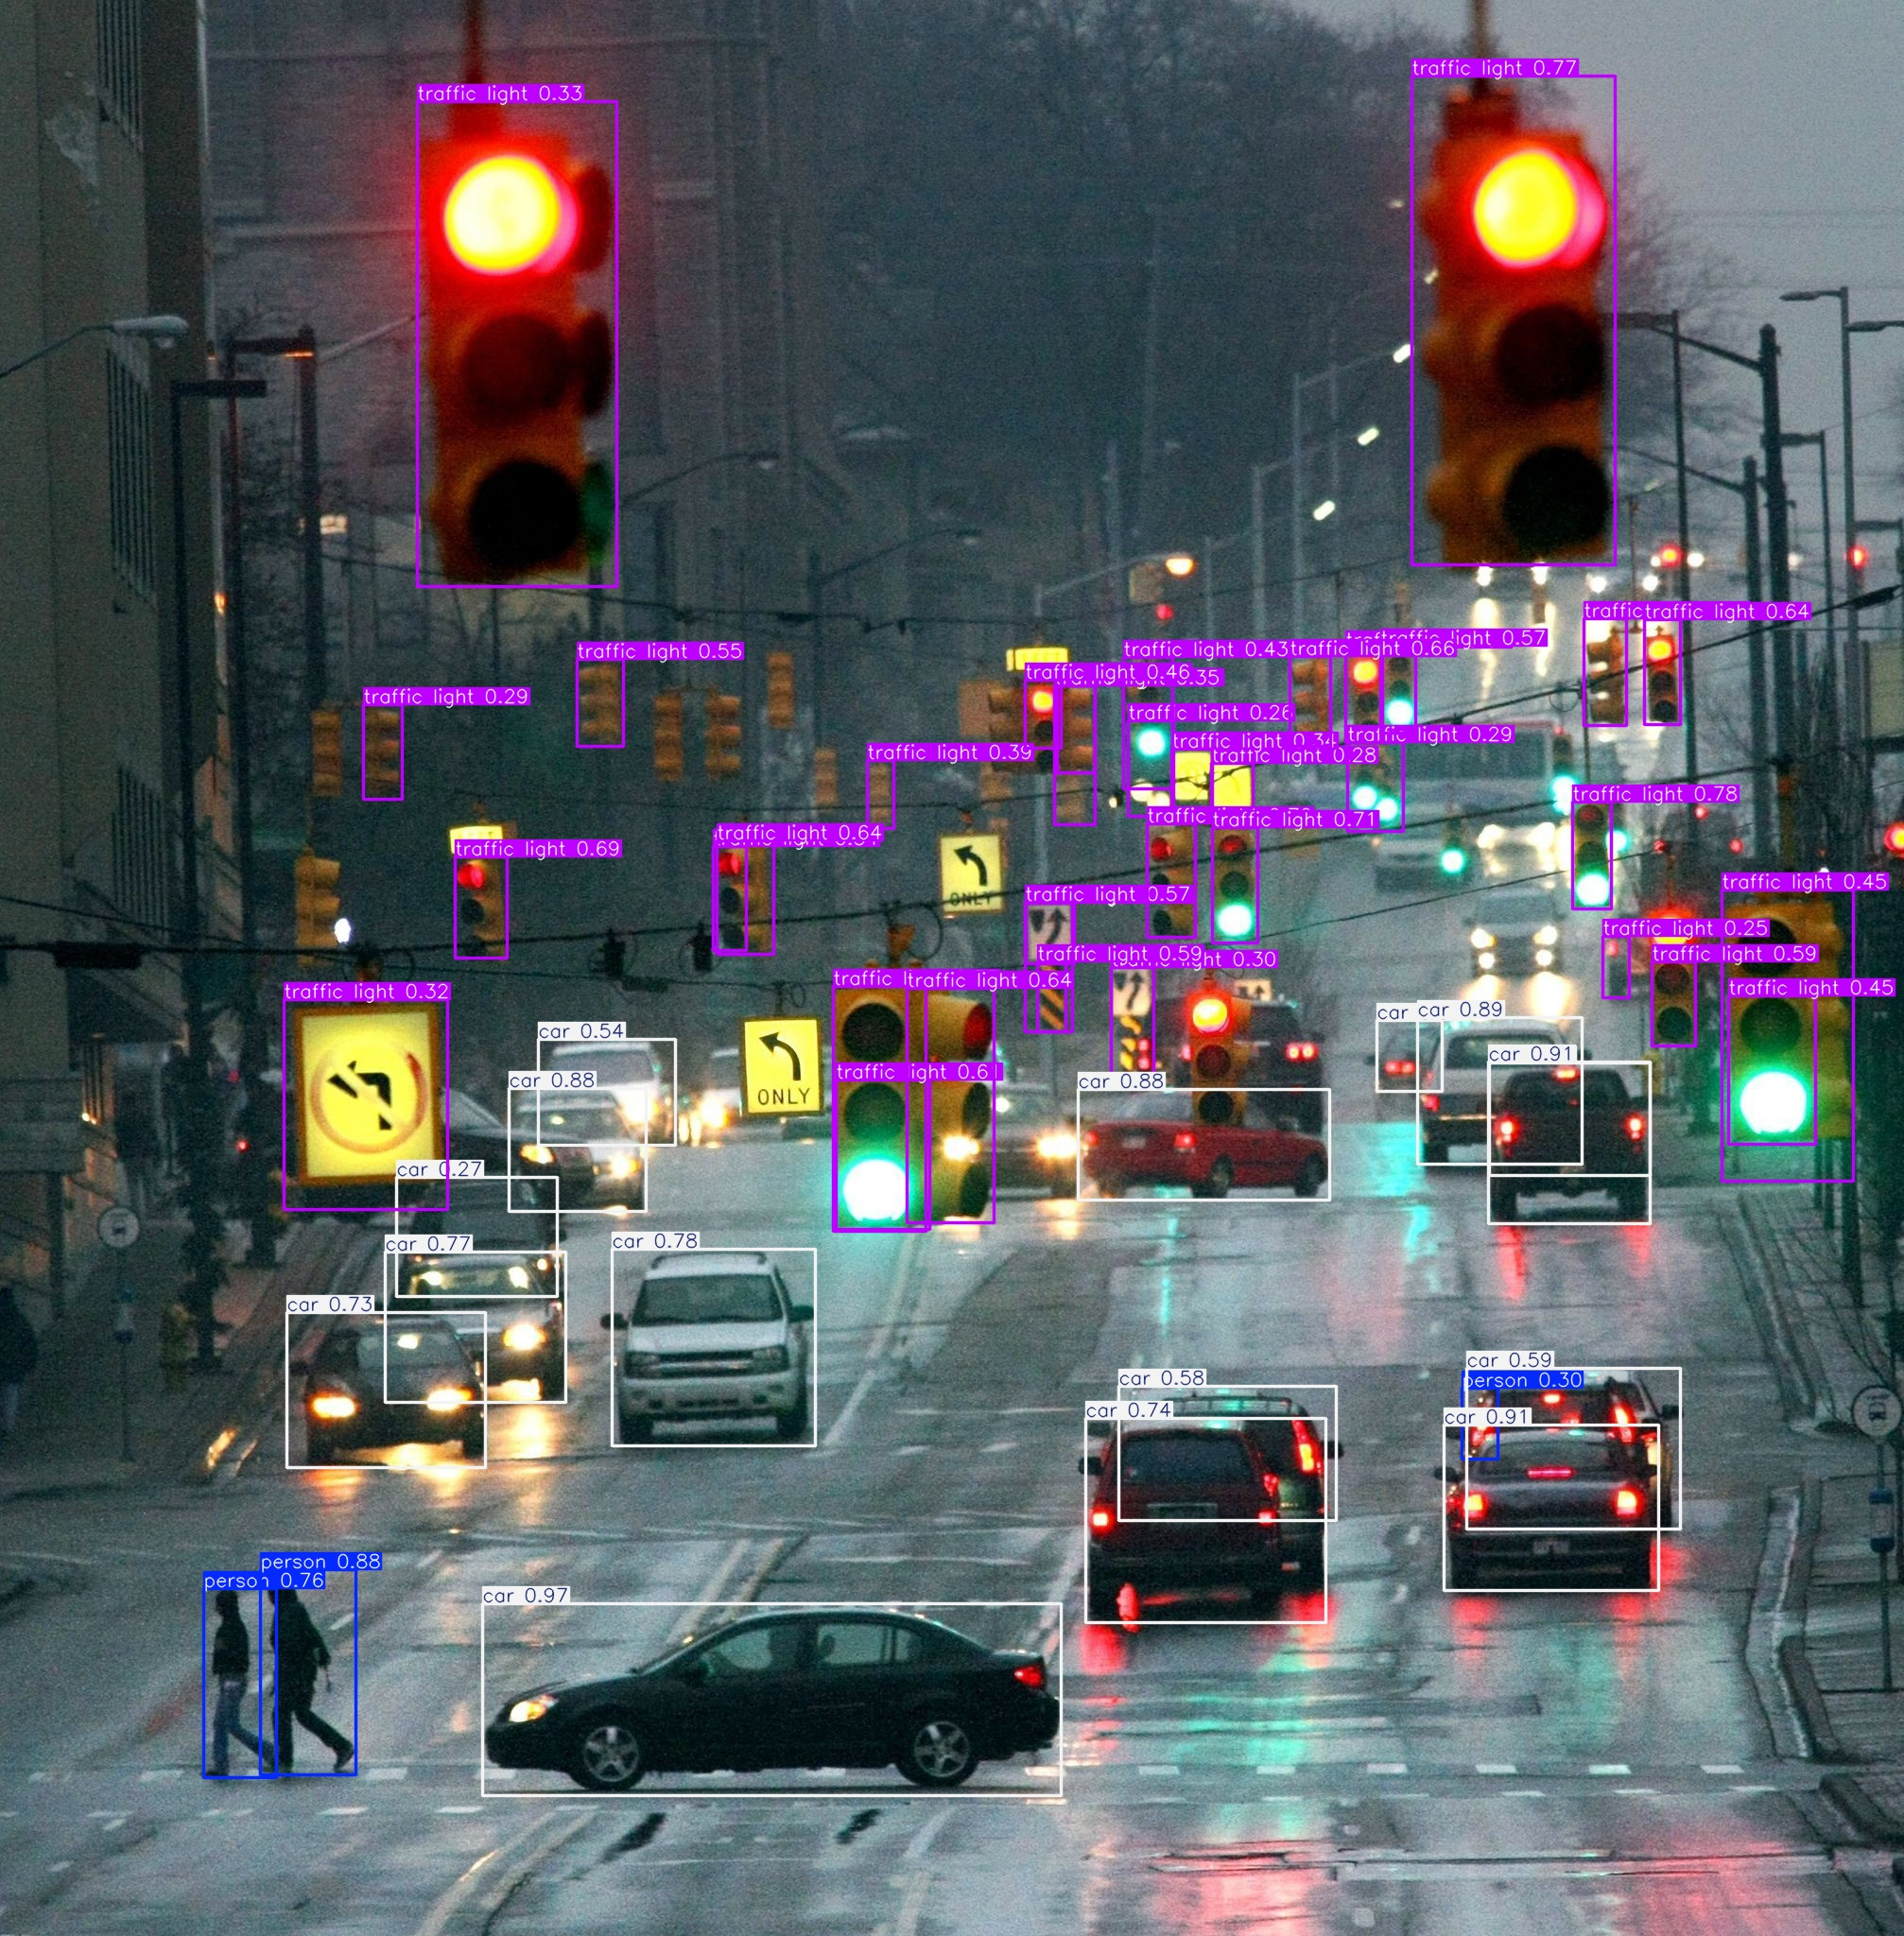

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


In [32]:
# prompt: plot this image /content/runs/detect/predict6/fulton-street-traffic-signals-synchronized-45d0b70ef344b19f.jpg and resize it to 700

from IPython.display import Image
Image('/content/runs/detect/predict/fulton-street-traffic-signals-synchronized-45d0b70ef344b19f.jpg', width=900)